# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [259]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from sklearn.preprocessing import MinMaxScaler


In [260]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio description 

In [261]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [262]:
portfolio.shape

(10, 6)

In [263]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### Uniqueness 

In [264]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [265]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [266]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [267]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

### Null values 

In [268]:
# Calculate null values in portfolio dataframe
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

### Clean Portfolio Data:
* portfolio: rename id col name to offer_id.
* portfolio: one-hot encode channels
* portfolio: one-hot encode offer_type column
* scale and normalise columns difficulty and reward
* re-order columns 
* convert time feature from days to hours


In [269]:
# renaming 'id' column to offer_id.
portfolio.rename(columns={'id':'offer_id'},inplace=True)

# Make separate columns for values in feature channels list
portfolio['web'] = portfolio['channels'].apply(lambda x: int(1) if 'web' in x else int(0))
portfolio['email'] = portfolio['channels'].apply(lambda x: int(1) if 'email' in x else int(0))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int(1) if 'mobile' in x else int(0))
portfolio['social'] = portfolio['channels'].apply(lambda x: int(1) if 'social' in x else int(0))

# Make separate columns for values in feature offer type list
#portfolio['bogo'] = portfolio['offer_type'].apply(lambda x: int(1) if 'bogo' in x else int(0))
#portfolio['informational'] = portfolio['offer_type'].apply(lambda x: int(1) if 'informational' in x else int(0))
#portfolio['discount'] = portfolio['offer_type'].apply(lambda x: int(1) if 'discount' in x else int(0))

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
columns_to_scale = ['difficulty','reward']
portfolio[columns_to_scale] = scaler.fit_transform(portfolio[columns_to_scale])

#Convert time feature from days to hours
portfolio['duration_hour'] = portfolio['duration']*24

# Drop duration and channels
portfolio.drop(columns=['duration', 'channels'],axis=1, inplace=True)

portfolio

,difficulty,offer_id,offer_type,reward,web,email,mobile,social,duration_hour
0,0.50,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0,0,1,1,1,168
1,0.50,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0,1,1,1,1,120
2,0.00,3f207df678b143eea3cee63160fa8bed,informational,0.0,1,1,1,0,96
3,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5,1,1,1,0,168
4,1.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5,1,1,0,0,240
5,0.35,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,0.3,1,1,1,1,168
6,0.50,fafdcd668e3743c1bb461111dcafc2a4,discount,0.2,1,1,1,1,240
7,0.00,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,0,1,1,1,72
8,0.25,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0.5,1,1,1,1,120
9,0.50,2906b810c7d4411798c6938adc9daaa5,discount,0.2,1,1,1,0,168


In [270]:
portfolio.isnull().sum(0)

difficulty       0
offer_id         0
offer_type       0
reward           0
web              0
email            0
mobile           0
social           0
duration_hour    0
dtype: int64

In [271]:
portfolio.dtypes

difficulty       float64
offer_id          object
offer_type        object
reward           float64
web                int64
email              int64
mobile             int64
social             int64
duration_hour      int64
dtype: object

In [272]:
portfolio.shape

(10, 9)

## Profile description 

In [273]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [274]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [275]:
profile.shape

(17000, 5)

In [276]:
# checking the number unique customers
profile['id'].nunique()

17000

In [277]:
# Calculate null values in profile dataframe
profile.isnull().sum(0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

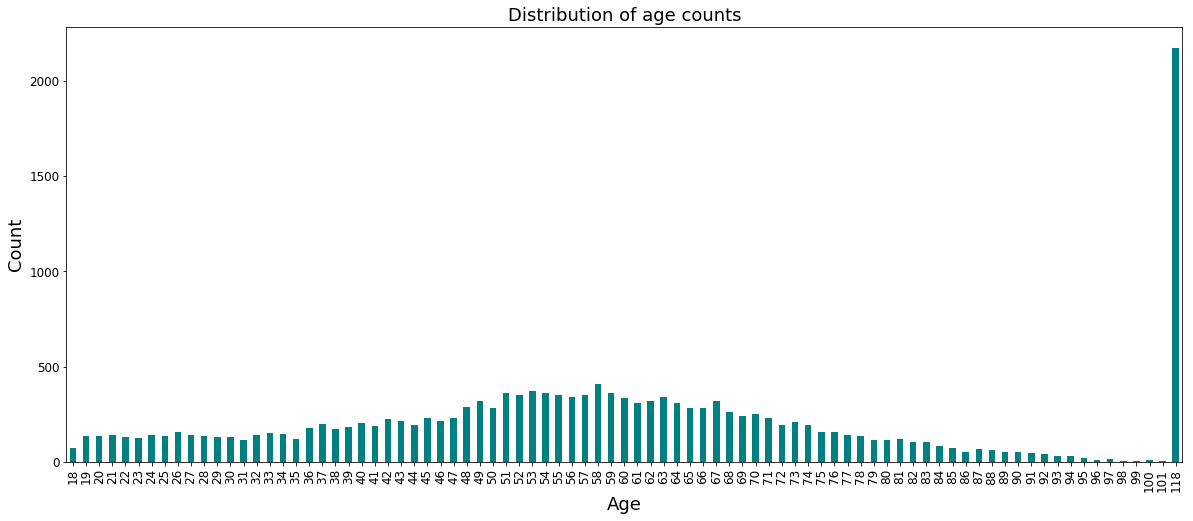

In [278]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,8), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts', fontsize=18)
plt.show()

Customers with age 118 seems to be an outlier, where the number of customers with age 118 is 2175, which is unrealistic and will be dropped fromt the dataframe.  

In [279]:
#Gender counts 
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### Clean Profile Data
* rename id col name to customer_id.
* encode age value 118 to NaN.
* create readable date format in became_member_on column.
* drop rows with no gender, income, age data
* convert gender values to numeric 0s and 1s
* convert age and income from float to int 
* add start year and start month columns (for further analysis)

In [280]:
from datetime import datetime

#rename id col name to customer_id.
profile.rename(columns={'id':'customer_id'},inplace=True)

#encode age value 118 to NaN
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

#create readable date format for became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

# dropping rows with NaNs in 'age', 'gender' and 'income' columns
profile.dropna(inplace=True)

#encode gendr column
profile['gender'] = profile['gender'].map({'F': 1, 'M': 2, 'O': 3})

#add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

# changing the datatype of 'age' and 'income' columns to 'int'
profile[['age','income']] = profile[['age','income']].astype(int)

# adding a new column 'membership_days' ,that will present the number of days since the customer become a member
profile['membership_days'] = datetime.now() - profile['became_member_on']

# removing the 'days' unit
profile['membership_days'] = profile['membership_days'].dt.days

# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'
profile['member_type'] = pd.cut(profile['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

# Drop channels and offertype column
profile.drop(columns=['became_member_on','membership_days' ],axis=1, inplace=True)

# Re-arranging the columns to have 'customer_id' column the first column in dataset
profile = profile.reindex(columns=['customer_id', 'age', 'gender', 'income', 'start_year', 'start_month', 'member_type'])


profile.head()

,customer_id,age,gender,income,start_year,start_month,member_type
1,0610b486422d4921ae7d2bf64640c50b,55,1,112000,2017,7,regular
3,78afa995795e4d85b5d9ceeca43f5fef,75,1,100000,2017,5,regular
5,e2127556f4f64592b11af22de27a7932,68,2,70000,2018,4,new
8,389bc3fa690240e798340f5a15918d5c,65,2,53000,2018,2,new
12,2eeac8d8feae4a8cad5a6af0499a211d,58,2,51000,2017,11,new


In [281]:
# checking that the rows with missing values(NaNs) have been successfully dropped
profile.isna().sum()

customer_id    0
age            0
gender         0
income         0
start_year     0
start_month    0
member_type    0
dtype: int64

In [282]:
profile.dtypes

customer_id      object
age               int64
gender            int64
income            int64
start_year        int64
start_month       int64
member_type    category
dtype: object

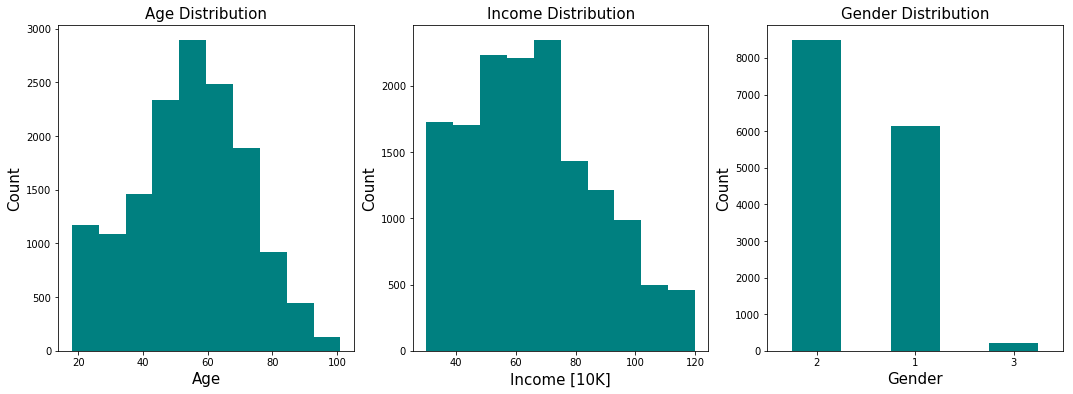

In [283]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=3)

# plot a age distribution in data
plt.sca(ax[0])
plt.hist(profile['age'], color ='teal')
plt.xlabel('Age',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Age Distribution',fontsize=15)

# plot a income distribution in data
plt.sca(ax[1])
plt.hist(profile['income'] * 1E-3, color ='teal')
plt.xlabel('Income [10K]',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Income Distribution',fontsize=15);

# plot a gender distribution in data
plt.sca(ax[2])
profile['gender'].value_counts().plot.bar(color='teal')
plt.xlabel('Gender',fontsize=15)
plt.xticks(rotation='horizontal')
plt.ylabel('Count',fontsize=15)
plt.title('Gender Distribution',fontsize=15);


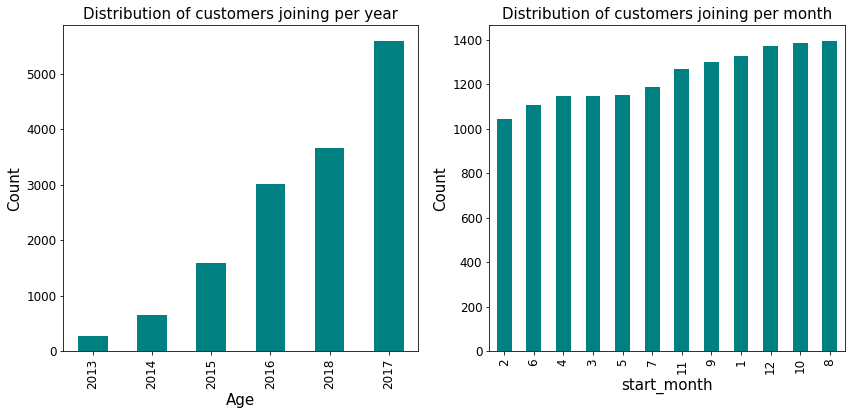

In [284]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)

# plot a start_year distribution
plt.sca(ax[0])
profile['start_year'].value_counts().sort_values(ascending=True).plot.bar(figsize=(14,6),fontsize=12,color='teal');
plt.xlabel('Age', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of customers joining per year', fontsize=15)

# plot a member_month distribution
plt.sca(ax[1])
profile['start_month'].value_counts().sort_values(ascending=True).plot.bar(figsize=(14,6),fontsize=12,color='teal');
plt.xlabel('start_month',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Distribution of customers joining per month',fontsize=15);

In [285]:
# Create gender_by_year_df dataframe to be used to create visualization
gender_by_year_df = pd.DataFrame(profile.groupby(['start_year'])['gender'].value_counts())
gender_by_year_df.rename(columns = {'gender': 'gender_count'}, inplace=True)
gender_by_year_df.reset_index(inplace=True)
gender_by_year_df

,start_year,gender,gender_count
0,2013,2,197
1,2013,1,74
2,2013,3,3
3,2014,2,520
4,2014,1,138
5,2014,3,4
6,2015,2,905
7,2015,1,663
8,2015,3,29
9,2016,1,1509


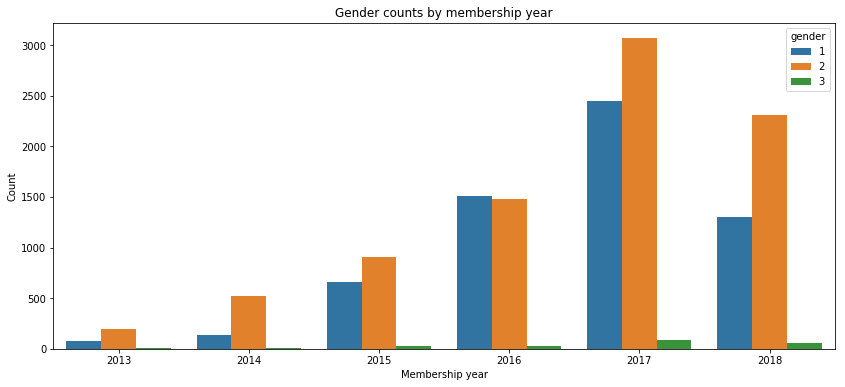

In [286]:
#Plot gender counts per membership year
fig, ax = plt.subplots(figsize=(14, 6),nrows=1, ncols=1)
sns.barplot(x='start_year', y='gender_count', hue='gender', data=gender_by_year_df)
plt.xlabel('Membership year')
plt.ylabel('Count')
plt.title('Gender counts by membership year')
plt.show()

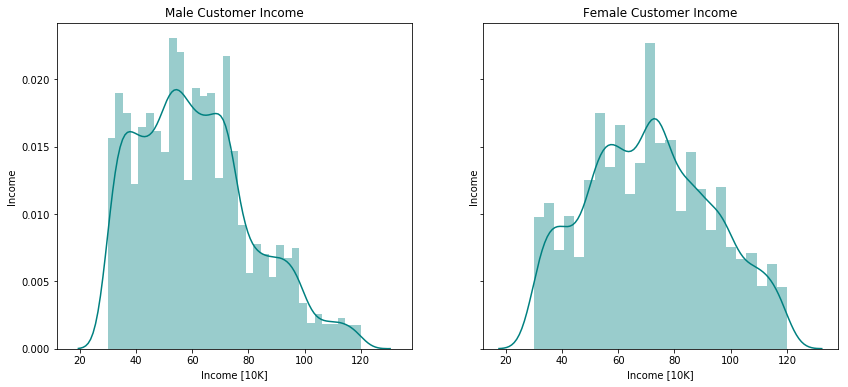

In [287]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(profile[profile['gender'] == 2]['income'] * 1E-3, color='teal')
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(profile[profile['gender'] == 1]['income'] * 1E-3,color='teal')
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income');

In [288]:
profile.head()

,customer_id,age,gender,income,start_year,start_month,member_type
1,0610b486422d4921ae7d2bf64640c50b,55,1,112000,2017,7,regular
3,78afa995795e4d85b5d9ceeca43f5fef,75,1,100000,2017,5,regular
5,e2127556f4f64592b11af22de27a7932,68,2,70000,2018,4,new
8,389bc3fa690240e798340f5a15918d5c,65,2,53000,2018,2,new
12,2eeac8d8feae4a8cad5a6af0499a211d,58,2,51000,2017,11,new


In [289]:
# Calculate null values in profile dataframe
profile.isnull().sum(0)

customer_id    0
age            0
gender         0
income         0
start_year     0
start_month    0
member_type    0
dtype: int64

In [290]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
customer_id    14825 non-null object
age            14825 non-null int64
gender         14825 non-null int64
income         14825 non-null int64
start_year     14825 non-null int64
start_month    14825 non-null int64
member_type    14825 non-null category
dtypes: category(1), int64(5), object(1)
memory usage: 825.3+ KB


In [291]:
profile.dtypes

customer_id      object
age               int64
gender            int64
income            int64
start_year        int64
start_month       int64
member_type    category
dtype: object

## Transaction description

In [292]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [293]:
transcript.shape

(306534, 4)

In [294]:
# Calculate null values in transcript dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [295]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [296]:
# Calculate the percentage of unique values in event feature
round((transcript['event'].value_counts()/transcript['event'].value_counts().sum())*100,2)

transaction        45.33
offer received     24.88
offer viewed       18.83
offer completed    10.95
Name: event, dtype: float64

In [297]:
def cleaning_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript - the cleaned offer dataframe
    
    '''
    #Change name of feature person to customer_id in transcript dataframe
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    
    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0  
    #Iterate over value column, check it and update offer_id, amount, reward columns
    for idx, row in transcript.iterrows():
        for k in row['value']:
            if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing
                transcript.at[idx, 'offer_id'] = row['value'][k]
            if k == 'amount':
                transcript.at[idx, 'amount'] = row['value'][k]
            if k == 'reward':
                transcript.at[idx, 'reward'] = row['value'][k]
                
    # map offer type to offer id           
    #offers_map = {
    #    'fafdcd668e3743c1bb461111dcafc2a4' : 'discount',
    #    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
    #    '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount',
    #    '2906b810c7d4411798c6938adc9daaa5':'discount',
    #    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
    #    '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo',
    #    '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo',
    #    'f19421c1d4aa40978ebb69ca19b0e20d':'bogo',
    #    '3f207df678b143eea3cee63160fa8bed':'informational',
    #    '5a8bc65990b245e5a138643cd4eb9837':'informational',    
    #}
    
    #create offer_type column 
    #transcript['offer_type'] = transcript['offer_id'].map(offers_map)
    
    # OneHotEncoding feature 'offer type'
    #transcript = pd.get_dummies(transcript, columns=['offer_type'], prefix='', prefix_sep='')
    
    # OneHotEncoding feature 'event'
    #transcript = pd.get_dummies(transcript, columns=['event'])
    
    # Change column names
    #transcript.rename(columns = {'event_offer received': 'offer_received',
    #                        'event_offer viewed': 'offer_viewed',
    #                        'event_offer completed': 'offer_completed'}, inplace=True)
    
    # Drop event_transaction since they cause missing values in 'order id' column 
    transcript = transcript[transcript['event'] != 'transaction']
    # Drop value column
    transcript.drop(columns=['value'], axis = 1, inplace = True)

    return transcript

In [298]:
cleaning_transcript_df=cleaning_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [299]:
cleaning_transcript_df.head()

,event,customer_id,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [300]:
cleaning_transcript_df.dtypes

event          object
customer_id    object
time            int64
offer_id       object
amount          int64
reward          int64
dtype: object

In [301]:
cleaning_transcript_df.shape

(167581, 6)

In [302]:
cleaning_transcript_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
event          167581 non-null object
customer_id    167581 non-null object
time           167581 non-null int64
offer_id       167581 non-null object
amount         167581 non-null int64
reward         167581 non-null int64
dtypes: int64(3), object(3)
memory usage: 8.9+ MB


In [303]:
# merge 'cleaning_transcript' dataset with 'profile' on 'offer_id'
master_df = cleaning_transcript_df.merge(portfolio,how='left',on='offer_id')

In [304]:
# join 'master_df' dataset with 'portfolio' on 'customer_id'
master_df = master_df.merge(profile,how='left',on='customer_id')

In [305]:
# checking our newely created master dataset
master_df.head()

,event,customer_id,time,offer_id,amount,reward_x,difficulty,offer_type,reward_y,web,email,mobile,social,duration_hour,age,gender,income,start_year,start_month,member_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0.25,bogo,0.5,1,1,1,0,168,75.0,1.0,100000.0,2017.0,5.0,regular
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1.00,discount,0.5,1,1,0,0,240,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,0.50,discount,0.2,1,1,1,0,168,68.0,2.0,70000.0,2018.0,4.0,new
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,0.50,discount,0.2,1,1,1,1,240,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0.50,bogo,1.0,1,1,1,1,120,NaN,NaN,NaN,NaN,NaN,NaN


In [306]:
# check if we have any missing values 
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 20 columns):
event            167581 non-null object
customer_id      167581 non-null object
time             167581 non-null int64
offer_id         167581 non-null object
amount           167581 non-null int64
reward_x         167581 non-null int64
difficulty       167581 non-null float64
offer_type       167581 non-null object
reward_y         167581 non-null float64
web              167581 non-null int64
email            167581 non-null int64
mobile           167581 non-null int64
social           167581 non-null int64
duration_hour    167581 non-null int64
age              148805 non-null float64
gender           148805 non-null float64
income           148805 non-null float64
start_year       148805 non-null float64
start_month      148805 non-null float64
member_type      148805 non-null category
dtypes: category(1), float64(7), int64(8), object(4)
memory usage: 25.7+ MB


In [307]:
# removing any row that contain NaNs
master_df = master_df.dropna(how='any',axis=0)

In [308]:
master_df.shape

(148805, 20)

## Master data analysis 

In [309]:
# creating a new column representing the age group to which the customer belongs 
master_df['age_group'] = pd.cut(master_df['age'], bins=[17, 22, 35, 60, 103],labels=['junior', 'adult', 'senior', 'elderly'])

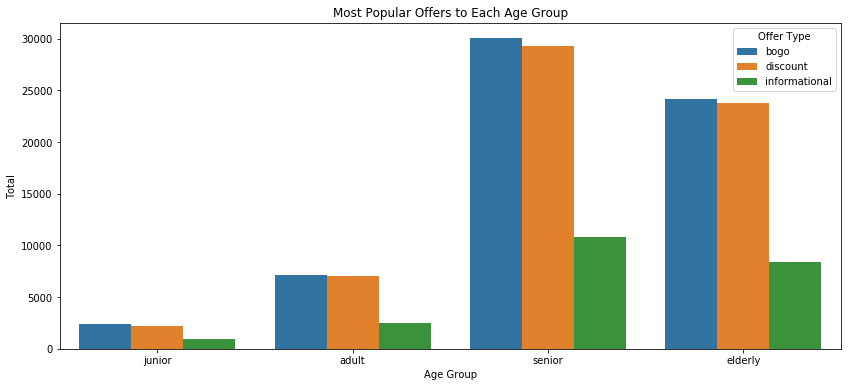

In [310]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['junior','adult','senior','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [311]:
# excluding all events of 'offer received' 
copy_master_df = master_df[master_df['event'] != 'offer received']
copy_master_df = copy_master_df[copy_master_df['event'] != 'transaction']
avg_time_spent_offer = copy_master_df.groupby(['gender', 'offer_id'])['time'].mean().reset_index()

print(avg_time_spent_offer[avg_time_spent_offer['gender'] == 1]['time'].values[0] / 24)
print(avg_time_spent_offer[avg_time_spent_offer['gender'] == 2]['time'].values[0] / 24)

16.9176908752
16.8795105395


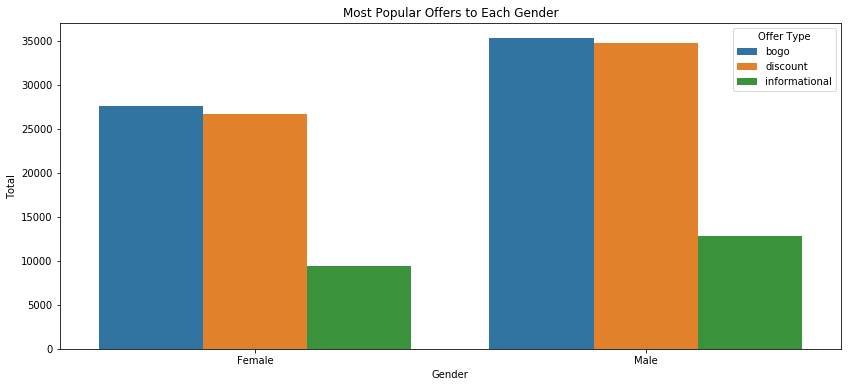

In [312]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= master_df[master_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

In [313]:
# excluding all events of 'offer received' 
avg_time_spent_offer = copy_master_df.groupby(['customer_id', 'offer_id'])['time'].mean().reset_index()
print('Average time to complete an offer:',avg_time_spent_offer['time'].mean() / 24)


Average time to complete an offer: 15.5103915438


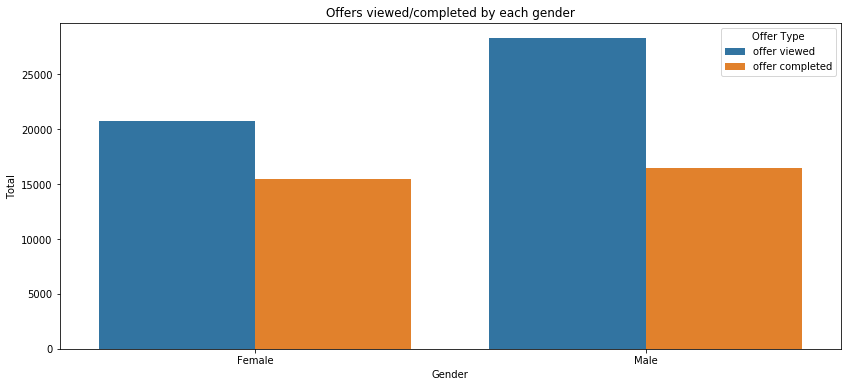

In [314]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= copy_master_df[copy_master_df["gender"] != 3])
plt.title('Offers viewed/completed by each gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();


In [315]:
trans_event_by_gender = master_df[master_df["gender"] != 3].groupby(['gender','event']).count()


In [316]:
print(f"Number of offer completed by Female: {trans_event_by_gender.loc[(1, 'offer completed')].values[0]}, {round((trans_event_by_gender.loc[(1, 'offer completed')].values[0]/trans_event_by_gender.loc[(1, 'offer viewed')].values[0])*100,2)}% of total offers viewed.")
print(f"Number of offer viewed by Female: {trans_event_by_gender.loc[(1, 'offer viewed')].values[0]}.")

      
print(f"Number of offer completed by Males: {trans_event_by_gender.loc[(2, 'offer completed')].values[0]}, {round((trans_event_by_gender.loc[(2, 'offer completed')].values[0]/trans_event_by_gender.loc[(2, 'offer viewed')].values[0])*100,2)}% of total offers viewed.")
print(f"Number of offer viewed by Males: {trans_event_by_gender.loc[(2, 'offer viewed')].values[0]}.")

Number of offer completed by Female: 15477, 74.46% of total offers viewed.
Number of offer viewed by Female: 20786.
Number of offer completed by Males: 16466, 58.18% of total offers viewed.
Number of offer viewed by Males: 28301.


## Data cleaning: Converting categorical values to numerical values

In [317]:
master_df.head()

,event,customer_id,time,offer_id,amount,reward_x,difficulty,offer_type,reward_y,web,...,mobile,social,duration_hour,age,gender,income,start_year,start_month,member_type,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0.25,bogo,0.5,1,...,1,0,168,75.0,1.0,100000.0,2017.0,5.0,regular,elderly
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,0.50,discount,0.2,1,...,1,0,168,68.0,2.0,70000.0,2018.0,4.0,new,elderly
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,0.25,bogo,0.5,1,...,1,1,120,65.0,2.0,53000.0,2018.0,2.0,new,elderly
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0,0.00,informational,0.0,1,...,1,0,96,58.0,2.0,51000.0,2017.0,11.0,new,senior
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1.00,discount,0.5,1,...,0,0,240,61.0,1.0,57000.0,2017.0,9.0,new,elderly


In [319]:
# OneHotEncoding feature 'offer type'
master_df = pd.get_dummies(master_df, columns = ['offer_type'], prefix= '', prefix_sep='')
    
# OneHotEncoding feature 'event'
master_df = pd.get_dummies(master_df, columns = ['event'], prefix= '', prefix_sep='')
    
# Change column names
master_df.rename(columns = {'event_offer received': 'offer_received',
                            'event_offer viewed': 'offer_viewed',
                            'event_offer completed': 'offer_completed'}, inplace=True)
    

    
#replacing the 'member_type' categorical labels by numerical labels
labels_member_type = master_df['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type = {'member_type' : {k: v for k,v in zip(labels_member_type,list(range(1,len(labels_member_type)+1)))}}
master_df.replace(replace_map_comp_member_type, inplace=True)

# replacing the 'age_group' categorical labels by numerical labels
labels_age_group = master_df['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}

# replace categorical labels in 'age_group' column with numerical labels
master_df.replace(replace_map_comp_age_group, inplace=True)

# Drop event_transaction
#master_df.drop(columns=['offer_type'], axis = 1, inplace = True)

In [322]:
master_df.head(5)

,customer_id,time,offer_id,amount,reward_x,difficulty,reward_y,web,email,mobile,...,start_year,start_month,member_type,age_group,bogo,discount,informational,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0.25,0.5,1,1,1,...,2017.0,5.0,2,4,1,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,0.50,0.2,1,1,1,...,2018.0,4.0,1,4,0,1,0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,0.25,0.5,1,1,1,...,2018.0,2.0,1,4,1,0,0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0,0.00,0.0,1,1,1,...,2017.0,11.0,1,3,0,0,1,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1.00,0.5,1,1,0,...,2017.0,9.0,1,4,0,1,0,0,1,0


## Data Modeling 